In [1]:
"""
Notebook Matrix Profile – ampiimts Python 3.11 package

Goal:
From pre processing signal with original value, normalize value, timestamp. 
We identify discord and motifs with a fix window on matrix profile methode (stumpy.maamp)
"""
import numpy as np
import pandas as pd
import ampiimts
import time
import os
import stumpy

In [4]:
#import files
folder = '../../dataset/pollution'
pds = []
with os.scandir(folder) as entries:
    for entry in entries:
        if entry.is_file() and entry.name.endswith('csv'):
            # list of sensors with some parameters -> list[pd.DataFrame[timestamp, value1, value2, etc..., latitude, longitude]]) 
            pds.append(pd.read_csv(folder+'/'+entry.name))
len(pds)
pds = pds[:2]
# and not entry.name.startswith('pollutionData')

In [5]:
pds_normalized = ampiimts.pre_processed(pds, sort_by_variables=True, window_size='24h')

mx_profile = ampiimts.matrix_profile(pds_normalized)



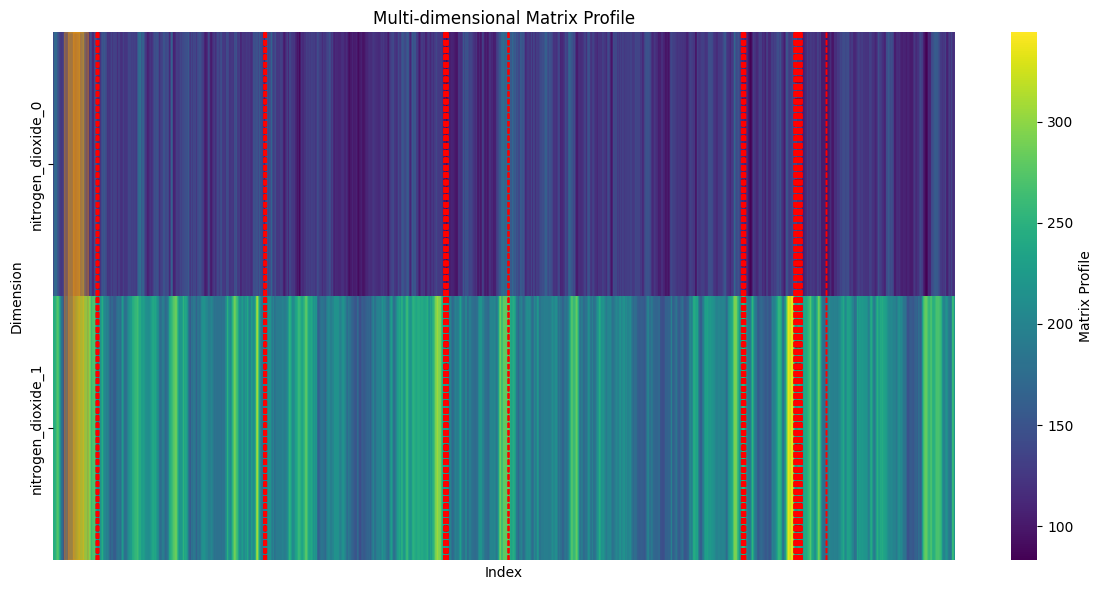

In [6]:
ampiimts.plot_multidim_matrix_profile(pds_normalized[1], mx_profile[1])

[]
Nombre de motifs trouvés : 1
Occurences pour chaque motif : [0]


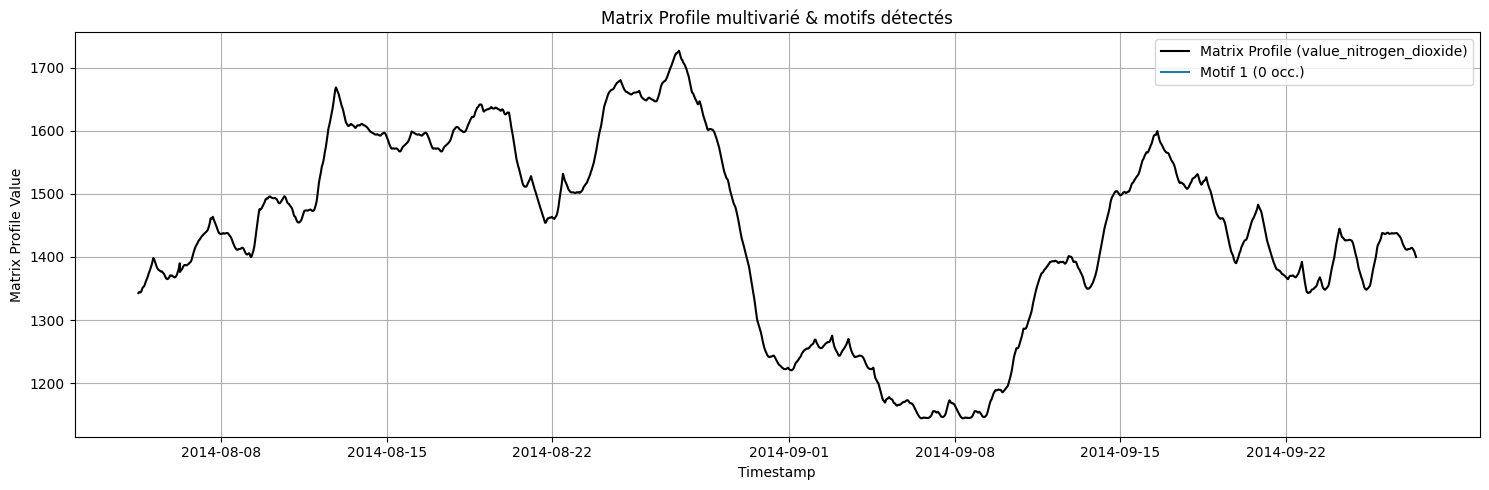

In [4]:
print(mx_profile[0]["motif_indices"])
print("Nombre de motifs trouvés :", len(mx_profile[0]["motif_indices"]))
print("Occurences pour chaque motif :", [len(m) for m in mx_profile[0]["motif_indices"]])

import matplotlib.pyplot as plt
def plot_mmotifs_results(
    mmotif_result,
    column_prefix="value_",
    motif_colors=None,
    figsize=(15, 5),
    show_legend=True
):
    """
    Affiche le matrix profile multivarié et surligne les motifs détectés.

    Args:
        mmotif_result (dict): Résultat retourné par ta fonction matrix_profile_process avec mmotifs.
        column_prefix (str): Préfixe des colonnes à afficher (ex : "value_" pour multivarié complet).
        motif_colors (list): Liste de couleurs pour les motifs (défaut : matplotlib tab10).
        figsize (tuple): Taille de la figure.
        show_legend (bool): Afficher ou non la légende.
    """
    df_profile = mmotif_result["profile"]
    motif_indices = mmotif_result["motif_indices"]
    window_size = motif_indices.shape[1] if len(motif_indices.shape) == 2 else len(motif_indices[0])
    # Par défaut, affiche le profil sur toutes les variables (la dernière colonne si multivarié)
    if column_prefix is None:
        # Prend la dernière colonne du DataFrame si aucune précisée
        column = df_profile.columns[-1]
    else:
        # Si multivarié, prends la/les bonnes colonnes automatiquement
        candidates = [col for col in df_profile.columns if col.startswith(column_prefix)]
        column = candidates[-1] if len(candidates) > 0 else df_profile.columns[0]

    plt.figure(figsize=figsize)
    plt.plot(df_profile.index, df_profile[column], label=f'Matrix Profile ({column})', color='black')
    
    # Couleurs pour les motifs détectés
    n_motifs = len(motif_indices)
    if motif_colors is None:
        motif_colors = plt.get_cmap("tab10").colors
    # Pour chaque motif détecté, surligne la fenêtre sur le plot
    for i, motif_group in enumerate(motif_indices):
        c = motif_colors[i % len(motif_colors)]
        for idx in motif_group:
            # Surligner la zone correspondant au motif trouvé
            start = df_profile.index[idx]
            stop_idx = idx + window_size
            stop = df_profile.index[min(stop_idx, len(df_profile)-1)]
            plt.axvspan(start, stop, color=c, alpha=0.15)
            plt.plot(df_profile.index[idx:stop_idx], df_profile[column].iloc[idx:stop_idx], color=c, linewidth=2)
        if show_legend:
            plt.plot([], [], color=c, label=f"Motif {i+1} ({len(motif_group)} occ.)")
    
    plt.title("Matrix Profile multivarié & motifs détectés")
    plt.xlabel("Timestamp")
    plt.ylabel("Matrix Profile Value")
    if show_legend:
        plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ampiimts.plot_all_variables_multiple_dfs(mx_profile)

plot_mmotifs_results(mx_profile[0])

In [5]:
pds_normalized = ampiimts.pre_processed(pds, sort_by_variables=True)
matrix_profiles = ampiimts.matrix_profile(pds_normalized)
ampiimts.plot_matrix_profiles_heatmap(matrix_profiles, 
                            time_index=matrix_profiles[0].index, 
                            capteur_labels=[f"Capteur {i+1}" for i in range(len(matrix_profiles))],
                            cmap="magma")  # Ou "viridis", "cubehelix", etc.


Best consensus window size(s): [(2016, '168h', np.float32(0.015951006), np.float64(0.0))]
Best consensus window size(s): [(2016, '168h', np.float32(0.014727033), np.float64(0.0))]
Best consensus window size(s): [(2016, '168h', np.float32(0.01693992), np.float64(0.0))]
Best consensus window size(s): [(2016, '168h', np.float32(0.011134193), np.float64(0.0))]
Best consensus window size(s): [(2016, '168h', np.float32(0.013316442), np.float64(0.0))]


KeyboardInterrupt: 